In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/analise-dados-dengue/__results__.html
/kaggle/input/analise-dados-dengue/__notebook__.ipynb
/kaggle/input/analise-dados-dengue/__output__.json
/kaggle/input/analise-dados-dengue/custom.css
/kaggle/input/analise-dados-dengue/__results___files/__results___15_0.png
/kaggle/input/analise-dados-dengue/__results___files/__results___14_0.png
/kaggle/input/analise-dados-dengue/__results___files/__results___28_1.png
/kaggle/input/analise-dados-dengue/__results___files/__results___26_1.png
/kaggle/input/analise-dados-dengue/__results___files/__results___24_0.png
/kaggle/input/analise-dados-dengue/__results___files/__results___29_1.png
/kaggle/input/analise-dados-dengue/__results___files/__results___35_0.png
/kaggle/input/analise-dados-dengue/__results___files/__results___36_0.png
/kaggle/input/analise-dados-dengue/__results___files/__results___21_0.png
/kaggle/input/analise-dados-dengue/__results___files/__results___27_1.png
/kaggle/input/analise-dados-dengue/__results___files/__re

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

In [10]:
# --- 1. Função para ler CSVs grandes em chunks ---
def ler_csv_grande(arquivo, ano, chunksize=100000):
    dfs = []
    print(f"Lendo {arquivo} em chunks...")
    for chunk in pd.read_csv(arquivo, chunksize=chunksize, low_memory=False):
        chunk["ANO"] = ano
        dfs.append(chunk)
    return pd.concat(dfs, ignore_index=True)

In [11]:
# --- 2. Ler e unir os arquivos de 2021 a 2024 ---
anos = [2021, 2022, 2023, 2024]
df_list = []

for ano in anos:
    arquivo = f"/kaggle/input/dados-sus-sinan-dengue-2021-2024/sinan_dengue_sample_{ano}.csv"
    df_ano = ler_csv_grande(arquivo, ano)
    df_list.append(df_ano)

df = pd.concat(df_list, ignore_index=True)
print(f"Total de linhas combinadas: {len(df)}")

Lendo /kaggle/input/dados-sus-sinan-dengue-2021-2024/sinan_dengue_sample_2021.csv em chunks...
Lendo /kaggle/input/dados-sus-sinan-dengue-2021-2024/sinan_dengue_sample_2022.csv em chunks...
Lendo /kaggle/input/dados-sus-sinan-dengue-2021-2024/sinan_dengue_sample_2023.csv em chunks...
Lendo /kaggle/input/dados-sus-sinan-dengue-2021-2024/sinan_dengue_sample_2024.csv em chunks...
Total de linhas combinadas: 5421888


In [15]:
# --- 3. Limpeza e transformação básica ---
df.columns = df.columns.str.upper()

# Sexo
sexo_map = {1: "Masculino", 2: "Feminino", 9: "Ignorado"}
df["CS_SEXO"] = df["CS_SEXO"].map(sexo_map).fillna("Desconhecido")

In [17]:
# Faixa etária
def faixa_etaria(idade):
    try:
        idade = int(idade)
        if idade <= 10: return "0-10"
        elif idade <= 20: return "11-20"
        elif idade <= 30: return "21-30"
        elif idade <= 40: return "31-40"
        elif idade <= 50: return "41-50"
        elif idade <= 60: return "51-60"
        else: return "61+"
    except:
        return "Ignorado"
df["FAIXA_ETARIA"] = df["NU_IDADE_N"].apply(faixa_etaria)

In [19]:
# Classificação final
classi_map = {
    1: "Confirmado laboratorialmente",
    2: "Confirmado clinicamente",
    3: "Descartado",
    4: "Inconclusivo",
    5: "Não classificado"
}
df["CLASSI_FIN"] = df["CLASSI_FIN"].map(classi_map).fillna("Ignorado")

In [20]:
# Evolução
evolucao_map = {1: "Cura", 2: "Óbito", 3: "Abandono", 9: "Ignorado"}
df["EVOLUCAO"] = df["EVOLUCAO"].map(evolucao_map).fillna("Desconhecido")

In [28]:
# --- 4. Funções para gráficos ---
def plotar_barra(data, x, y, titulo, xlabel="", ylabel="Casos", rot=45):
    plt.figure(figsize=(12,6))
    sns.barplot(data=data, x=x, y=y, palette="viridis")
    plt.title(titulo)
    plt.xlabel(xlabel if xlabel else x)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rot)
    plt.show()

def plotar_pizza(data, labels, valores, titulo):
    plt.figure(figsize=(7,7))
    plt.pie(valores, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(labels)))
    plt.title(titulo)
    plt.axis('equal')
    plt.show()

    ANO    Casos
0  2021  1010359
1  2022  1393877
2  2023  1508653
3  2024  1508999


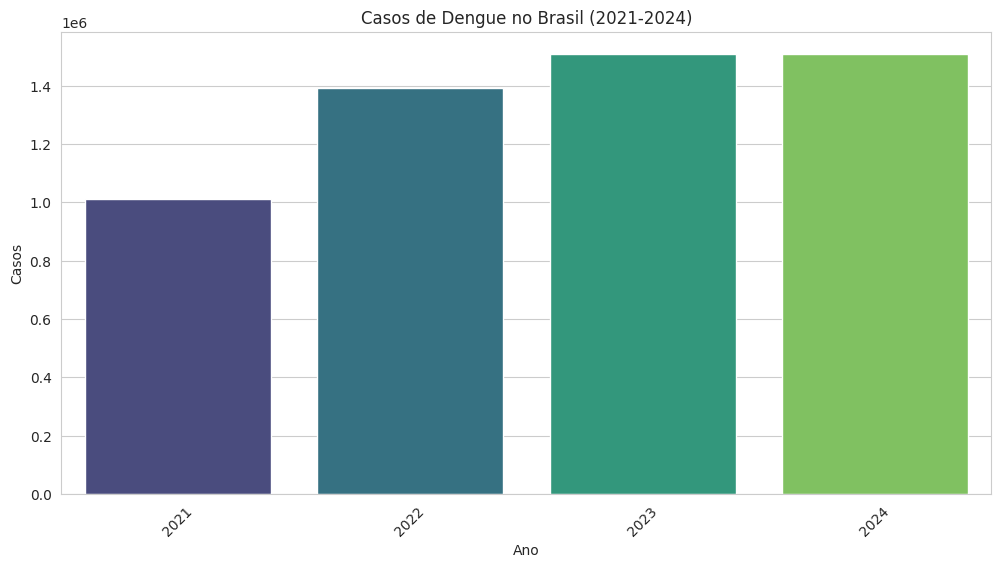

In [29]:
# --- 5. Análises (respostas às perguntas) ---

# 1) Casos por ano
casos_por_ano = df.groupby("ANO").size().reset_index(name="Casos")
print(casos_por_ano)
plotar_barra(casos_por_ano, "ANO", "Casos", "Casos de Dengue no Brasil (2021-2024)", xlabel="Ano")

    SG_UF_NOT   Casos
16         31  406035
18         35  337173
19         41  209397
20         42  142000
24         52   70117
17         33   49917
15         29   47419
22         50   45173
25         53   42121
21         43   38675


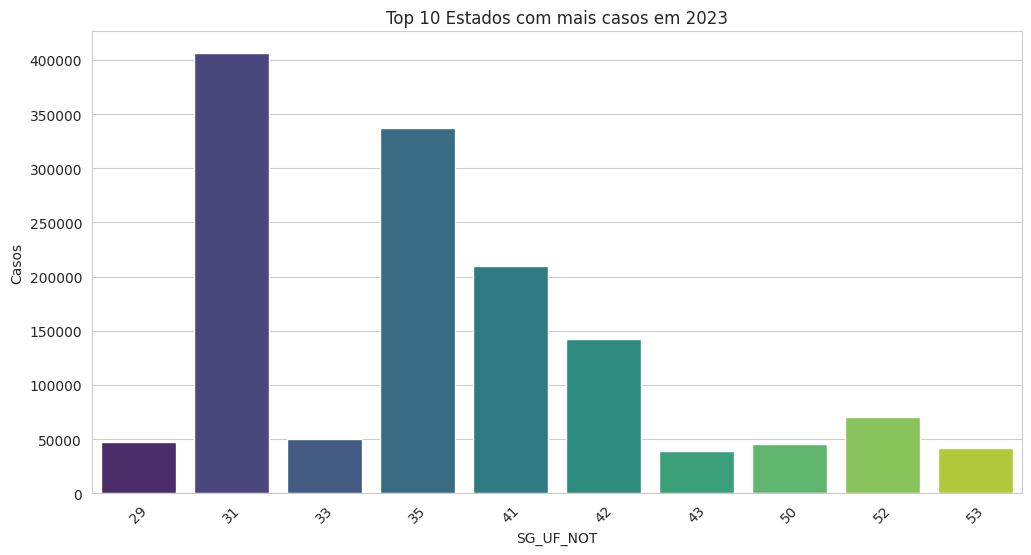

In [30]:
# 2) Estado com mais casos em 2023
df_2023 = df[df["ANO"]==2023]
casos_estado_2023 = df_2023.groupby("SG_UF_NOT").size().reset_index(name="Casos").sort_values(by="Casos", ascending=False)
print(casos_estado_2023.head(10))
plotar_barra(casos_estado_2023.head(10), "SG_UF_NOT", "Casos", "Top 10 Estados com mais casos em 2023")

  FAIXA_ETARIA    Casos
6          61+  1010202
0         0-10       45
2        21-30       37
3        31-40       23
1        11-20       18
5        51-60       18
4        41-50       16


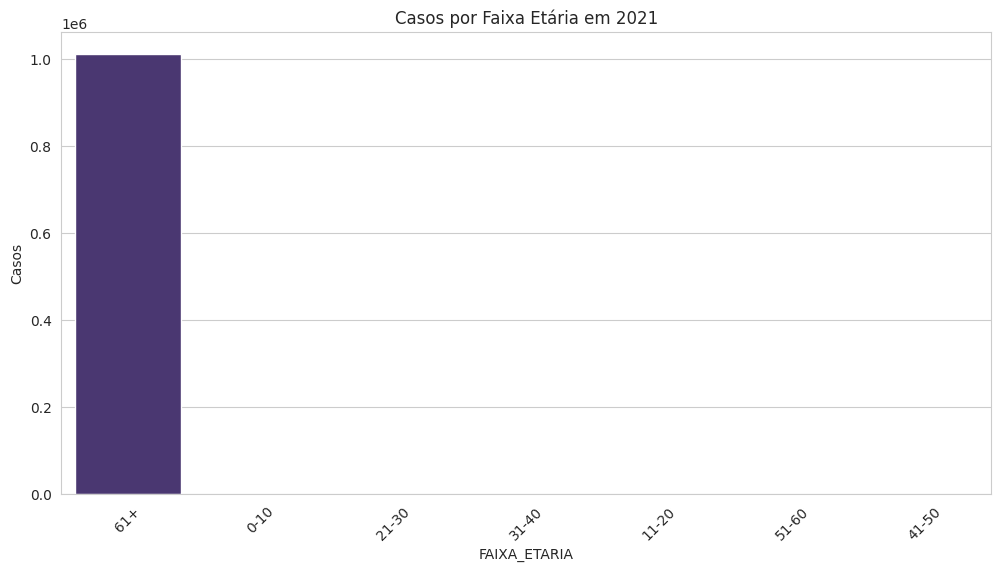

In [31]:
# 3) Faixa etária com mais casos em 2021
df_2021 = df[df["ANO"]==2021]
casos_faixa_2021 = df_2021.groupby("FAIXA_ETARIA").size().reset_index(name="Casos").sort_values(by="Casos", ascending=False)
print(casos_faixa_2021)
plotar_barra(casos_faixa_2021, "FAIXA_ETARIA", "Casos", "Casos por Faixa Etária em 2021")

        CS_SEXO    Casos
0  Desconhecido  1508999


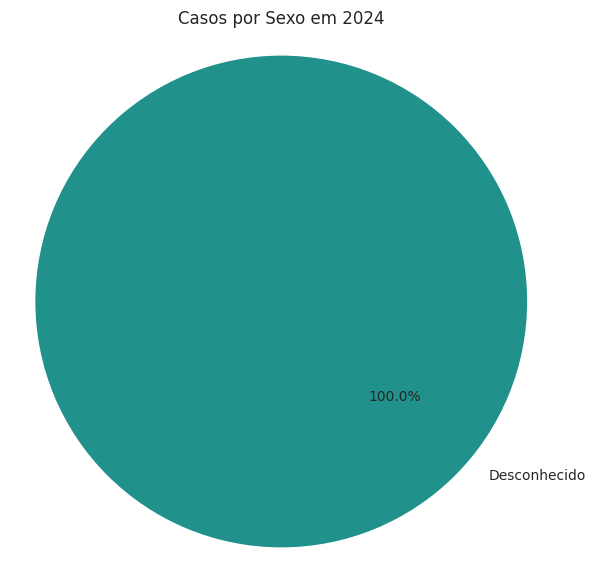

In [33]:
# 4) Sexo com mais casos em 2024
df_2024 = df[df["ANO"]==2024]
casos_sexo_2024 = df_2024.groupby("CS_SEXO").size().reset_index(name="Casos")
print(casos_sexo_2024)
plotar_pizza(casos_sexo_2024, casos_sexo_2024["CS_SEXO"], casos_sexo_2024["Casos"], "Casos por Sexo em 2024")

In [34]:
# 5) Casos graves por estado em 2023
casos_graves_2023 = df_2023[df_2023["CLASSI_FIN"]=="Confirmado laboratorialmente"]
casos_graves_estado_2023 = casos_graves_2023.groupby("SG_UF_NOT").size().reset_index(name="Casos")
print(casos_graves_estado_2023)
plotar_barra(casos_graves_estado_2023, "SG_UF_NOT", "Casos", "Casos Graves por Estado em 2023")

Empty DataFrame
Columns: [SG_UF_NOT, Casos]
Index: []


ValueError: min() arg is an empty sequence

<Figure size 1200x600 with 0 Axes>

      MUNICIPIO  Casos
496    280340.0      1
1168   410780.0      1
532    290840.0      1
533    290870.0      1
534    290930.0      1
535    290940.0      1
536    290970.0      1
537    291070.0      1
1346   421930.0      1
1169   410790.0      1


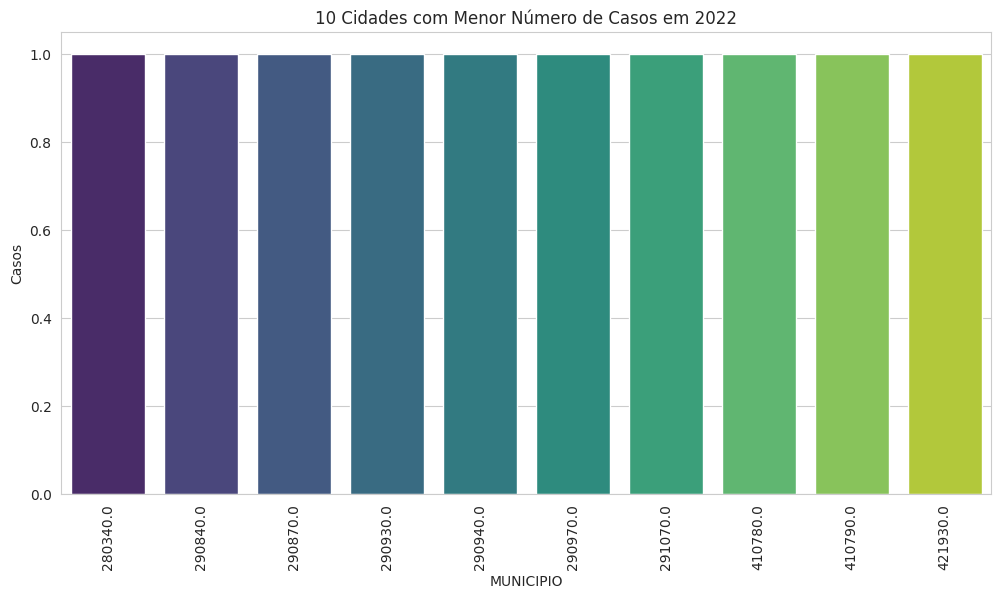

In [35]:
# 6) Cidade com menor número de casos em 2022
df_2022 = df[df["ANO"]==2022]
casos_cidade_2022 = df_2022.groupby("MUNICIPIO").size().reset_index(name="Casos").sort_values(by="Casos", ascending=True)
print(casos_cidade_2022.head(10))
plotar_barra(casos_cidade_2022.head(10), "MUNICIPIO", "Casos", "10 Cidades com Menor Número de Casos em 2022", rot=90)

In [37]:
# 7) Casos de 0 a 10 anos em 2021
casos_0_10_2021 = df_2021[(df_2021["NU_IDADE_N"].astype(float)>=0) & (df_2021["NU_IDADE_N"].astype(float)<=10)].shape[0]
print(f"Casos de 0 a 10 anos em 2021: {casos_0_10_2021}")

Casos de 0 a 10 anos em 2021: 45


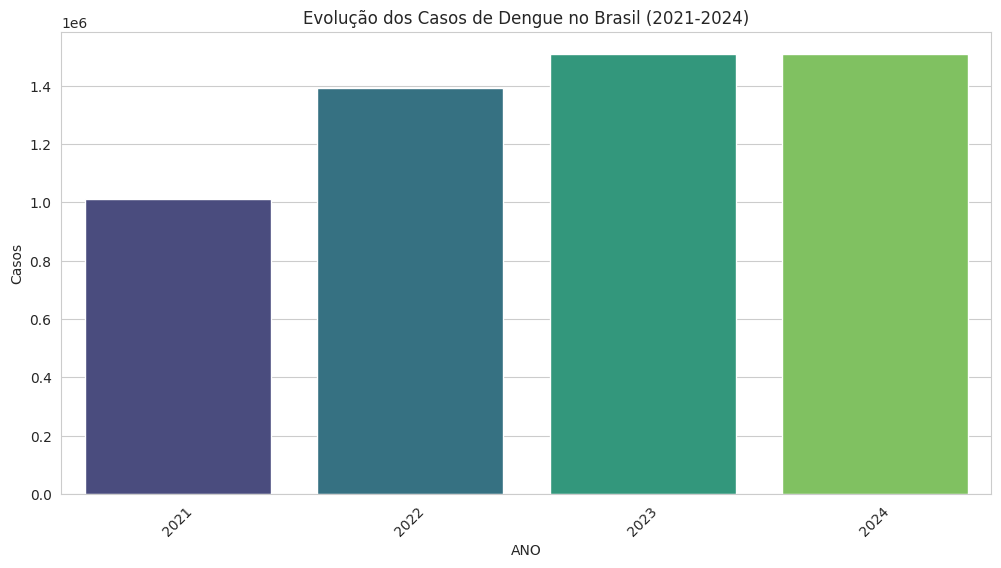

In [38]:
# 8) Evolução anual
plotar_barra(casos_por_ano, "ANO", "Casos", "Evolução dos Casos de Dengue no Brasil (2021-2024)")

  CLASSI_FIN    Casos
0   Ignorado  1508653


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


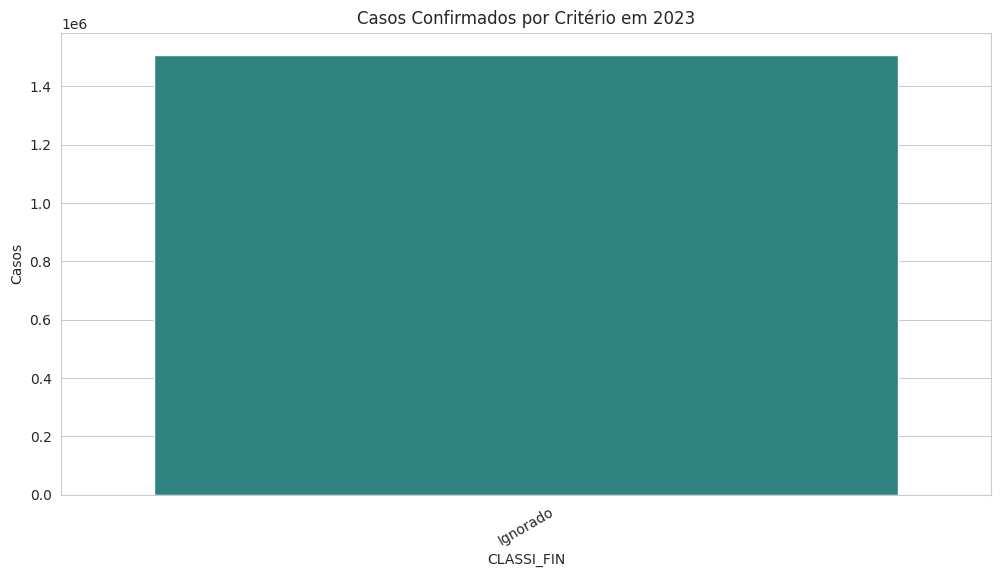

In [39]:
# 9) Confirmados laboratorialmente vs clinicamente em 2023
classificacao_2023 = df_2023.groupby("CLASSI_FIN").size().reset_index(name="Casos")
print(classificacao_2023)
plotar_barra(classificacao_2023, "CLASSI_FIN", "Casos", "Casos Confirmados por Critério em 2023", rot=30)

    SG_UF_NOT  Casos_2022  Casos_2023  Diferença
16         31       89041      406035     316994
20         42       85274      142000      56726
19         41      156187      209397      53210
17         33       11138       49917      38779
22         50       26328       45173      18845
15         29       35724       47419      11695
1          12        3425        7173       3748
5          16         290        1220        930
2          13        5356        6265        909
3          14          62         224        162
4          15        5912        5688       -224
7          21        6850        4799      -2051
14         28        5244        2952      -2292
0          11       14252       10700      -3552
23         51       35341       28605      -6736
12         26       16106        7977      -8129
18         35      350891      337173     -13718
6          17       20846        3294     -17552
11         25       28839        7196     -21643
8          22       

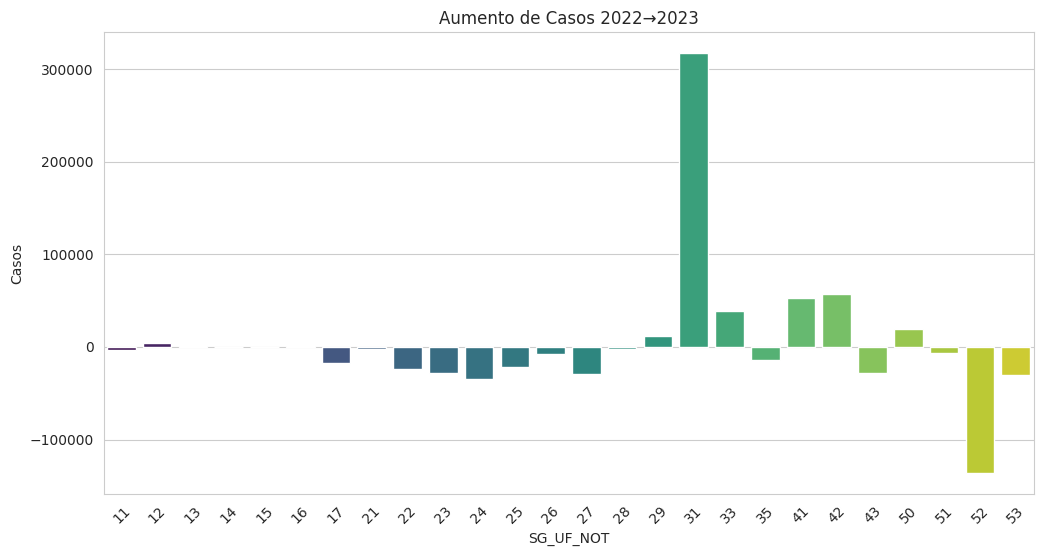

In [40]:
# 10) Maior aumento de 2022 para 2023 por estado
casos_2022 = df_2022.groupby("SG_UF_NOT").size().reset_index(name="Casos_2022")
casos_2023 = df_2023.groupby("SG_UF_NOT").size().reset_index(name="Casos_2023")
aumento = pd.merge(casos_2022, casos_2023, on="SG_UF_NOT", how="outer").fillna(0)
aumento["Diferença"] = aumento["Casos_2023"] - aumento["Casos_2022"]
print(aumento.sort_values(by="Diferença", ascending=False))
plotar_barra(aumento.sort_values(by="Diferença", ascending=False), "SG_UF_NOT", "Diferença", "Aumento de Casos 2022→2023")